## Initializing and Loading Data

In [1]:
file_location = "TMDB_movie_dataset_v11.csv"

In [2]:
import pandas as pd
import numpy as np

In [3]:
backup = pd.read_csv(file_location)

### Backup

In [4]:
data = backup.copy(deep=True)

## Initial Data Cleaning

In [5]:
initial = len(data)
before = initial
initial

1104439

### Getting rid of duplicate rows

In [6]:
data = data.drop_duplicates()
after = len(data)
print(f"Removed {(before - after)} duplicate rows. {after} rows left.")
before = after

Removed 366 duplicate rows. 1104073 rows left.


### Removing unreleased movies

The status column shows what stage of production the movie is in. We are only concerned with movies that have been released.

In [7]:
data.status.value_counts()

status
Released           1080967
In Production         8753
Post Production       7412
Planned               6321
Rumored                323
Canceled               297
Name: count, dtype: int64

Getting rid of unreleased movies:

In [8]:
data = data[data['status'] == "Released"]
after = len(data)
print(f"Removed {before - after} unreleased movies. {after} rows left.")
before = after

Removed 23106 unreleased movies. 1080967 rows left.



The release date of some rows are in the future, even though they are marked as `'Released'`. `release_date` is currently an `object` type and needs to be converted to a `datetime` type to be handled.

In [9]:
data['release_date'] = pd.to_datetime(data['release_date'])
data.release_date.describe()

count                           924375
mean     1999-11-03 19:22:06.237079040
min                1800-01-01 00:00:00
25%                1989-01-01 00:00:00
50%                2010-07-30 00:00:00
75%                2018-10-15 00:00:00
max                2061-12-07 00:00:00
Name: release_date, dtype: object

Dropping all movies with a release date in the future:

In [10]:
from datetime import date
today = pd.to_datetime(date.today())
data = data[data['release_date'] < today]
after = len(data)
print(f"Removed {before - after} future movies. {after} rows left.")
before = after

Removed 156706 future movies. 924261 rows left.


In [11]:
data.release_date.describe()

count                           924261
mean     1999-11-02 14:47:01.860059904
min                1800-01-01 00:00:00
25%                1989-01-01 00:00:00
50%                2010-07-29 00:00:00
75%                2018-10-14 00:00:00
max                2024-10-24 00:00:00
Name: release_date, dtype: object

Now the status column can be dropped.

In [12]:
data = data.drop(columns='status')
data.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'release_date', 'revenue',
       'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords'],
      dtype='object')

### Removing porn

The `adult` column designates if a row is an adult film. These will be dropped:

In [13]:
data = data[data['adult'] == False]
after = len(data)
print(f"Removed {before - after} adult films. {after} rows left.")
before = after

Removed 91413 adult films. 832848 rows left.


### Getting rid of duplicate IDs

In [14]:
print(f"There are {before - data.id.nunique()} rows with a repeated id.")

There are 7 rows with a repeated id.


Lower indexed entries are more up-to-date and more complete. Removing rows with duplicated IDs, only keeping the first occurance.

In [15]:
data = data.drop_duplicates(subset=['id'], keep='first')
after = len(data)
print(f"Removed {before - after} duplicate IDs. {after} rows left.")
before = after

Removed 7 duplicate IDs. 832841 rows left.


In [16]:
data.id.nunique()

832841

### Dropping unnecessary columns

Checking columns:

In [17]:
data.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'release_date', 'revenue',
       'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords'],
      dtype='object')

In [18]:
data[['backdrop_path', 'homepage', 'imdb_id', 'poster_path']].describe()

,backdrop_path,homepage,imdb_id,poster_path
count,256521,100460,521876,626295
unique,254408,94834,521641,622903
top,/3CxwYgqGtJ6UEGfWUT0gMYCIlFP.jpg,https://animation.geidai.ac.jp,tt32094375,/wtoKLMm4UvkwvcSwO3XWcs1gJuF.jpg
freq,157,147,16,54


The `backdrop_path`,`homepage`, `imdb_id`, and `poster_path` columns do not contain any useful data. These can be dropped.

In [19]:
data = data.drop(columns=['backdrop_path', 'homepage', 'poster_path'])
data.columns

Index(['id', 'title', 'vote_average', 'vote_count', 'release_date', 'revenue',
       'runtime', 'adult', 'budget', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'tagline', 'genres',
       'production_companies', 'production_countries', 'spoken_languages',
       'keywords'],
      dtype='object')

## Analyzing columns

### `title`

In [20]:
data.title.describe()

count     832837
unique    717044
top         Home
freq         124
Name: title, dtype: object

### `vote_average`

In [21]:
data.vote_average.describe()

count    832841.000000
mean          2.320404
std           3.149025
min           0.000000
25%           0.000000
50%           0.000000
75%           5.400000
max          10.000000
Name: vote_average, dtype: float64

<Axes: ylabel='Frequency'>

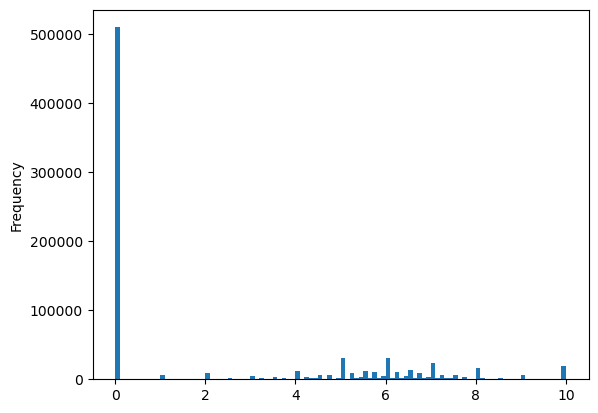

In [22]:
data.vote_average.plot.hist(bins=100)

In [23]:
len(data.query('vote_count == 0 and vote_average != 0'))

462

There are an overwhelmingly large amount of $0.0$ vote averages. This is because they have $0$ `vote_count`. It's inappropriate to consider a movie with no votes to be $0.0$ on a $1\text{-}10$ scale that does not permit 0. These should be replaced with `NaN`.

<Axes: ylabel='Frequency'>

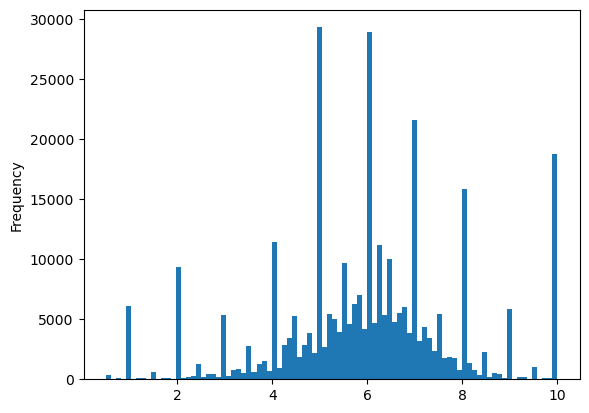

In [24]:
data.vote_average.replace(0, np.nan, inplace=True)
data.vote_average.plot.hist(bins=90)

### `vote_count`

In [25]:
data.vote_count.describe()

count    832841.000000
mean         25.701104
std         371.859660
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max       34495.000000
Name: vote_count, dtype: float64

<Axes: ylabel='Frequency'>

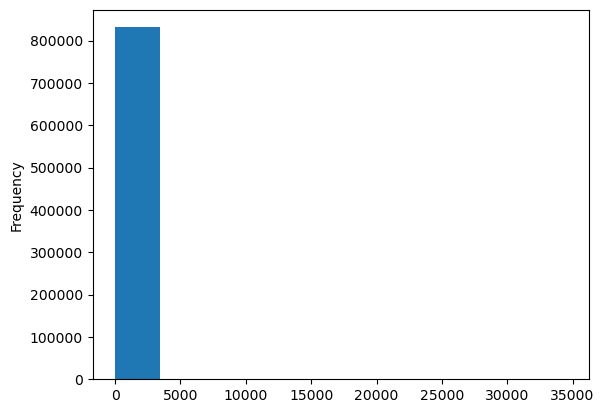

In [26]:
data.vote_count.plot.hist()

### `release_date`

In [27]:
type(data['release_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [28]:
data[data['release_date'] == data['release_date'].min()]

,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
702570,1294302,בראול סטארס בחיים האמיתיים-אלון קאט,NaN,0,1800-01-01,100000000,0,False,0,NaN,he,בראול סטארס בחיים האמיתיים-אלון קאט,NaN,0.6,NaN,"Horror, Drama, Thriller, Mystery, War",Salty Fish,NaN,NaN,NaN


In [29]:
data.release_date.sort_values().head()

702570   1800-01-01
605145   1800-09-11
640928   1837-10-29
289005   1865-01-01
570689   1865-01-01
Name: release_date, dtype: datetime64[ns]

In [30]:
data.iloc[640928]

id                                                                 380446
title                                                    Taken for a Ride
vote_average                                                          NaN
vote_count                                                              0
release_date                                          1931-01-31 00:00:00
revenue                                                                 0
runtime                                                                 0
adult                                                               False
budget                                                                  0
imdb_id                                                         tt0152862
original_language                                                      en
original_title                                           Taken for a Ride
overview                After a running gun battle through the streets...
popularity                            

In [31]:
data[data['release_date'] < pd.to_datetime('1900-01-01')]

,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
7186,160,The Arrival of a Train at La Ciotat,7.112,425,1897-10-10,0,1,False,0,tt0000012,fr,L'arrivée d'un train à La Ciotat,"Likely in June 1897, a group of people are sta...",10.495,NaN,Documentary,Lumière,France,No Language,"france, cinema on cinema, beginning, train, ea..."
9027,774,Workers Leaving the Lumière Factory,6.685,297,1895-03-22,0,1,False,0,tt0000010,fr,La Sortie de l'Usine Lumière à Lyon,Working men and women leave through the main g...,9.641,NaN,Documentary,Lumière,France,No Language,"factory worker, factory, lyon, closing time, h..."
10876,82120,The Sprinkler Sprinkled,6.896,225,1895-06-10,0,1,False,0,tt0000014,fr,Arroseur et arrosé,"A gardener is watering his flowers, when a mis...",6.428,NaN,Comedy,"Lumière, Société des Etablissements L. Gaumont",France,No Language,"prank, spanking, gardener, prankster, short film"
12410,16463,Roundhay Garden Scene,6.351,184,1888-10-14,0,1,False,0,tt0392728,xx,Roundhay Garden Scene,"The earliest surviving celluloid film, and bel...",7.347,One man will walk harder than he's ever walked...,Documentary,Whitley Partners,United Kingdom,No Language,"walking, hat, garden, historical, short film"
12942,104700,The Astronomer's Dream,6.831,172,1898-01-01,0,3,False,0,tt0000211,fr,La lune à un mètre,An astronomer has a terrifying dream.,7.002,NaN,Fantasy,Star Film Company,France,No Language,"moon, nightmare, astronomer, silent film, shor..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101066,712203,Fighting the Fire,NaN,0,1898-11-03,0,1,False,0,tt0203498,en,Fighting the Fire,Shows steam fire engine in action. Men scale l...,0.600,NaN,Documentary,Edison Studios,United States of America,NaN,NaN
1102629,719504,La bandera argentina,NaN,0,1897-01-01,0,3,False,0,tt0199351,es,La bandera argentina,The Argentinian flag waving at the Plaza de Ma...,0.600,NaN,NaN,NaN,Argentina,No Language,NaN
1103336,715807,The Haverstraw Tunnel,NaN,0,1897-06-15,0,1,False,0,tt0217537,en,The Haverstraw Tunnel,A train travels along the tracks of the West S...,0.600,NaN,Documentary,American Mutoscope & Biograph,United States of America,NaN,NaN
1104386,717261,Ancoradouro de Pescadores na Baía de Guanabara,NaN,0,1897-01-01,0,0,False,0,tt1743298,pt,Ancoradouro de Pescadores na Baía de Guanabara,"First Brazillian film, actuality film showing ...",0.600,NaN,NaN,NaN,Brazil,NaN,NaN


<Axes: >

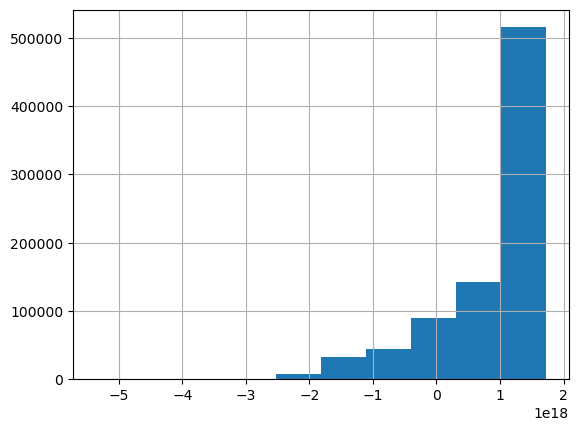

In [32]:
pd.to_numeric(data['release_date']).hist()



```
# This is formatted as code
```

# Reducing the scale

Reducing the dataset to include modern films (any film released after 1/1/1900) and feature films (defined as any film longer than 40 minutes long).

In [72]:
clean_file_location = "clean.csv"

In [73]:
backup_clean = pd.read_csv(clean_file_location)

In [74]:
data_clean = backup_clean.copy(deep=True)

In [78]:
data_clean['release_date'] = pd.to_datetime(data_clean['release_date'], format="%Y-%m-%d")

In [79]:
modern_films = data_clean[data_clean['release_date'] > pd.to_datetime('1900-01-01')]

In [80]:
modern_feature_films = modern_films[modern_films['runtime'] > 40]

In [81]:
modern_feature_films = modern_feature_films.dropna(subset=['imdb_id'])

In [82]:
modern_feature_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314210 entries, 0 to 832834
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            314210 non-null  int64         
 1   id                    314210 non-null  int64         
 2   title                 314210 non-null  object        
 3   vote_average          206475 non-null  float64       
 4   vote_count            314210 non-null  int64         
 5   release_date          314210 non-null  datetime64[ns]
 6   revenue               314210 non-null  int64         
 7   runtime               314210 non-null  float64       
 8   adult                 314210 non-null  bool          
 9   budget                314210 non-null  int64         
 10  imdb_id               314210 non-null  object        
 11  original_language     314210 non-null  object        
 12  original_title        314210 non-null  object        
 13  over

In [83]:
modern_feature_films.head()

,Unnamed: 0,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,...,original_language,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,0,27205,Inception,8.364,34495,2010-07-15,825532764,148.0,False,160000000,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169.0,False,165000000,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152.0,False,185000000,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162.0,False,237000000,...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143.0,False,220000000,...,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [37]:
# Missing attributes to go find
# overview
# genre
# production company
# language
# keywords

In [38]:
# For movies with keywords, I think we don't need to do any web-scrapping

In [39]:
# For movies without keywords, we probably need to do some extra work.
# We can get more information from online or just rely on the plot.
# Maybe we use the plot to get keywords???

# NLP (actual)

# NLP testing


In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.1/29.1 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 104.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that

In [ ]:
!pip install spacy spacy-universal-sentence-encoder

In [41]:
!pip install https://github.com/MartinoMensio/spacy-universal-sentence-encoder/releases/download/v0.4.6/en_use_lg-0.4.6.tar.gz#en_use_lg-0.4.6

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tensorflow-macos to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [38]:
import spacy
import spacy_universal_sentence_encoder

In [39]:
nlp = spacy.load('en_use_lg')

In [84]:
def vectorize(genres):
    return [nlp(genre).vector for genre in genres]

In [89]:
working_df = modern_feature_films.copy()

In [133]:
import ast

working_df['genres'] = working_df['genres'].str.lower()

# Split the genres by comma and strip any leading/trailing whitespace
working_df['genres'] = working_df['genres'].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)

all_genres = working_df['genres'].explode()

unique_genres = all_genres.unique().tolist()


In [134]:
unique_genres.pop(19)

nan

In [135]:
unique_genres

['action',
 'science fiction',
 'adventure',
 'drama',
 'crime',
 'thriller',
 'fantasy',
 'comedy',
 'romance',
 'western',
 'mystery',
 'war',
 'animation',
 'family',
 'horror',
 'music',
 'history',
 'tv movie',
 'documentary']

In [142]:
non_null_working_df = working_df.dropna(subset=['genres'], inplace=False)

In [91]:
non_null_working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278705 entries, 0 to 832834
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Unnamed: 0            278705 non-null  int64         
 1   id                    278705 non-null  int64         
 2   title                 278705 non-null  object        
 3   vote_average          193252 non-null  float64       
 4   vote_count            278705 non-null  int64         
 5   release_date          278705 non-null  datetime64[ns]
 6   revenue               278705 non-null  int64         
 7   runtime               278705 non-null  float64       
 8   adult                 278705 non-null  bool          
 9   budget                278705 non-null  int64         
 10  imdb_id               278705 non-null  object        
 11  original_language     278705 non-null  object        
 12  original_title        278705 non-null  object        
 13  over

In [146]:
#non_null_working_df.loc[:, 'genres'] = non_null_working_df['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

In [147]:
non_null_working_df['genres']

0                  [action, science fiction, adventure]
1                   [adventure, drama, science fiction]
2                      [drama, action, crime, thriller]
3         [action, adventure, fantasy, science fiction]
4                  [science fiction, action, adventure]
                              ...                      
832783                                  [comedy, drama]
832797                                    [documentary]
832821                                          [drama]
832831                           [documentary, history]
832834                                  [drama, comedy]
Name: genres, Length: 278705, dtype: object

In [111]:
# Find the length of the genres list for each movie
#working_df['num_genres'] = working_df['genres'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#max_genres = working_df['num_genres'].max()
#min_genres = working_df['num_genres'].min()

In [112]:
min_genres = 1

In [92]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [51]:
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [53]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [54]:
embeddings = embed(unique_genres)

#reduce to 1 dimension
pca = PCA(n_components=1)
mappings = pca.fit_transform(embeddings)

# Map genres to their corresponding 1D values
vectorized_genres = {genre: value for genre, value in zip(unique_genres, mappings)}

In [139]:
vectorized_genres

{'action': array([-0.10550172]),
 'science fiction': array([0.11262273]),
 'adventure': array([-0.16961193]),
 'drama': array([0.17274052]),
 'crime': array([-0.0995075]),
 'thriller': array([0.5790899]),
 'fantasy': array([-0.0173265]),
 'comedy': array([0.34058345]),
 'romance': array([0.09965853]),
 'western': array([-0.53399636]),
 'mystery': array([0.14538536]),
 'war': array([-0.22306778]),
 'animation': array([-0.20076975]),
 'family': array([-0.33277005]),
 'horror': array([0.44501432]),
 'music': array([-0.01332231]),
 'history': array([-0.17695217]),
 'tv movie': array([0.07989143]),
 'documentary': array([-0.10216017])}

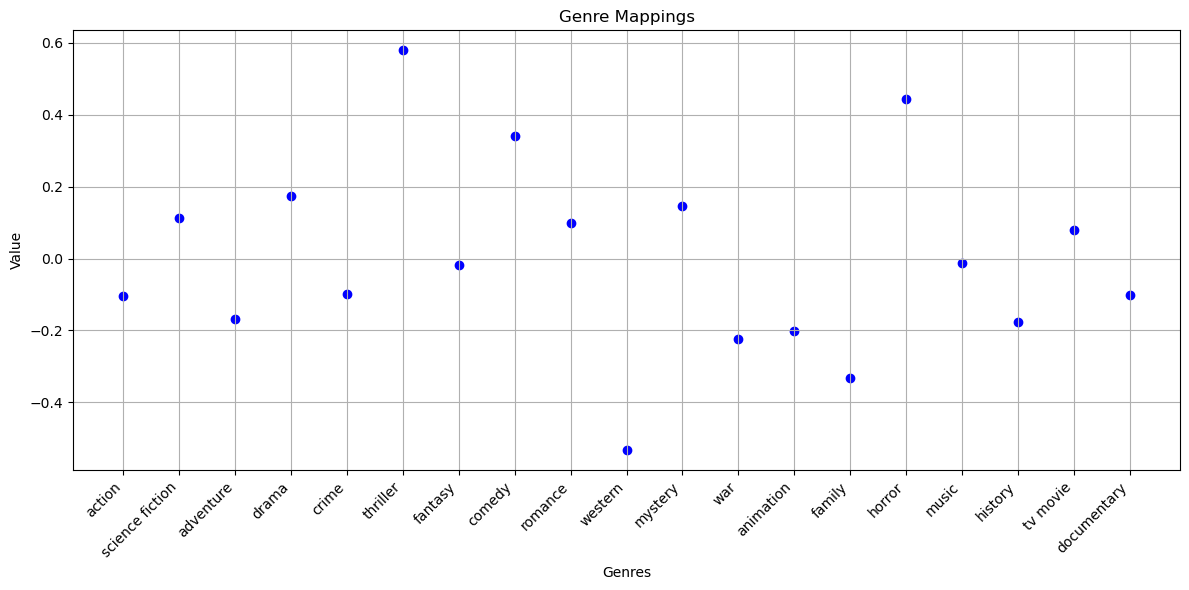

In [56]:
import matplotlib.pyplot as plt

# Extracting genres and their corresponding 1D values
genres = list(vectorized_genres.keys())
values = [value[0] for value in vectorized_genres.values()]  # Flatten the 1D values

# Plotting the points
plt.figure(figsize=(12, 6))
plt.scatter(genres, values, color='blue')
plt.title('Genre Mappings')
plt.xlabel('Genres')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')  # Rotate genre labels for better visibility
plt.grid()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [143]:
vectorirzed_df = non_null_working_df.copy()

In [144]:
vectorirzed_df['genres'] = vectorirzed_df['genres'].apply(lambda genre_list: [vectorized_genres[genre] for genre in genre_list] if isinstance(genre_list, list) else genre_list)

In [145]:
vectorirzed_df.head()

,Unnamed: 0,id,title,vote_average,vote_count,release_date,revenue,runtime,adult,budget,...,original_title,overview,popularity,tagline,genres,production_companies,production_countries,spoken_languages,keywords,num_genres
0,0,27205,Inception,8.364,34495,2010-07-15,825532764,148.0,False,160000000,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,Your mind is the scene of the crime.,"[[-0.1055017234478468], [0.11262273444579632],...","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",0
1,1,157336,Interstellar,8.417,32571,2014-11-05,701729206,169.0,False,165000000,...,Interstellar,The adventures of a group of explorers who mak...,140.241,Mankind was born on Earth. It was never meant ...,"[[-0.1696119336204439], [0.17274051760378853],...","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",0
2,2,155,The Dark Knight,8.512,30619,2008-07-16,1004558444,152.0,False,185000000,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,Welcome to a world without rules.,"[[0.17274051760378853], [-0.1055017234478468],...","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f...",0
3,3,19995,Avatar,7.573,29815,2009-12-15,2923706026,162.0,False,237000000,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,Enter the world of Pandora.,"[[-0.1055017234478468], [-0.1696119336204439],...","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ...",0
4,4,24428,The Avengers,7.710,29166,2012-04-25,1518815515,143.0,False,220000000,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,Some assembly required.,"[[0.11262273444579632], [-0.1055017234478468],...",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com...",0


In [132]:
# Reduce to min-D for every genre vector?
# Should we use 2D instead of 1D for the genre mappings?
# I need the data from the web scrapping

In [135]:
# reduce the dimensionality of each genre vector to min_genres dimensions

In [137]:
# plot every movie on min_genres-D space (we should be able to recall the movie as well)

In [138]:
# when new movie comes in, we get the genre
# plot on graph
# BOOM -> get the k nearest movies and return those movies

In [140]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 MB 46.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 12.0 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 19.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [60]:
import torch
import torch.nn as nn

In [113]:
class SetTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=16, num_heads=4, hidden_dim=128):
        super(SetTransformer, self).__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.pool = nn.Linear(embed_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embed(x)  # Embed the input into a higher-dimensional space
        x = x.transpose(0, 1)  # Required shape for MultiheadAttention: [seq_length, batch_size, embed_dim]
        attn_output, _ = self.self_attention(x, x, x)
        pooled_output = torch.mean(attn_output, dim=0)  # Mean pooling across the set
        output = self.output_layer(self.pool(pooled_output))
        return output

In [114]:
# Parameters
input_dim = 1  # Genres in 1d space
embed_dim = 16
num_heads = 4
output_dim = min_genres

set_transformer = SetTransformer(input_dim=input_dim, output_dim=output_dim, embed_dim=embed_dim, num_heads=num_heads)

In [115]:
def dimension_reduction(genres):
    genre_tensor = torch.tensor(genres, dtype=torch.float).unsqueeze(1)  # Add a dummy dimension for input
    return set_transformer(genre_tensor).detach().numpy()

In [148]:
vectorirzed_df['reduced_genre_vectors'] = vectorirzed_df['genres'].apply(lambda genres: dimension_reduction(genres))

In [2]:
########
########
#APPLYING TO INPUT MOVIE
########
########

In [150]:
def vectorize_input_genres(genre_list):
    genre_list: [vectorized_genres[genre] for genre in genre_list]

In [151]:
vectorize_input_genres(input_genres)

NameError: name 'input_genres' is not defined

In [ ]:
########
########
#FINDING THE MOST SIMILAR MOVIES
########
########
from sklearn.neighbors import NearestNeighbors

database_values = vectorirzed_df['reduced_genre_vectors'].values.reshape(-1, 1)  # Reshape for KNN 
input_value = [[genre] for genre in input_genres]                            # Reshape for KNN 

k = 3
knn = NearestNeighbors(n_neighbors=k)
knn.fit(database_values)

neighbors = knn.kneighbors(input_value, return_distance=False)


In [ ]:
plt.plot(vectorirzed_df['reduced_genre_vectors'], marker='o', linestyle='none', color='black') 

plt.plot(input_genres, marker='x', linestyle='none', color='red')

In [ ]:
# Highlight k-nearest neighbors
for idx, genre in enumerate(input_genres):
    neighbor_indices = neighbors[idx]
    plt.plot(neighbor_indices, vectorirzed_df['reduced_genre_vectors'].iloc[neighbor_indices], marker='s', linestyle='none', color='green', 
             label=f'{k} nearest to y' if idx == 0 else "")  # Avoid duplicate labels

plt.show()

In [4]:
########
########
#RETURNING THE TITLES
########
########

In [ ]:
titles = vectorirzed_df['title'].to_numpy()

nearest_titles = [titles[indices] for indices in neighbors]